In [2]:
import pandas as pd
import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score

from skrules import SkopeRules # in skope_rules.py, from sklearn.externals import six must be changed with import six. Also there, you have to change from collections import Counter, Iterable must be changed
# with from collections import Counter and from collections.abc import Iterable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import matplotlib.pyplot as plt
import os
from os.path import exists

from utilsData import *
from SkopeAlgorithm import *
from UtilsModel import *

import warnings as w
w.filterwarnings('ignore')

import seaborn as sns
from scipy.stats import mannwhitneyu

In [3]:
data_path = "simulationVictorTopological/"
datafilename = "dataset.csv"

res_path = "simulationVictorTopological/skope/"
if not exists(res_path):
    os.mkdir(res_path)
    
output = "output"

# Train, test, calibration loading

In [4]:
# Verifica si el archivo existe en la carpeta
if os.path.exists(os.path.join(data_path, "train.csv")):
    print("Train.csv exists")
else:
    data = pd.read_csv(data_path+datafilename)
    n_tr = 4000
    n_ts = 1000
    n_c = 5000
    split_dataset(data.drop(["NumberOfCollisions"],axis = 1).values,data.iloc[:,3].values,n_tr,n_ts,n_c,save_path=data_path)


Split Done


In [5]:
data = pd.read_csv(data_path+"dataset.csv")
data[output] = data["NumberOfCollisions"].apply(lambda x: 1 if x > 0 else x)
data = data.drop(["NumberOfCollisions"],axis = 1)

train = pd.read_csv(data_path+"train.csv")
train[output] = train[output].apply(lambda x: 1 if x > 0 else x)
y_train = train[output]
X_train = train.iloc[:, 3:15] # si quieres solo caracteristicas topol: train.iloc[:, 3:7] 
#si quieres caracteristicas simulaciones + caract topol: train.drop([output],axis = 1

calib = pd.read_csv(data_path+"calib.csv")
calib[output] = calib[output].apply(lambda x: 1 if x > 0 else x)
y_cal = calib[output]
X_cal = calib.iloc[:, 3:15] 

test = pd.read_csv(data_path+"test.csv")
test[output] = test[output].apply(lambda x: 1 if x > 0 else x)
y_test = test[output]
X_test = test.iloc[:, 3:15] 


# Exploratory analisis

## Correlation

In [6]:
correlation_matrix = data.corr()
print(correlation_matrix)

                     SafetyMargin       Eta       Tau  meanEntropy  \
SafetyMargin             1.000000  0.001146  0.012468     0.901893   
Eta                      0.001146  1.000000 -0.016431     0.087053   
Tau                      0.012468 -0.016431  1.000000    -0.277889   
meanEntropy              0.901893  0.087053 -0.277889     1.000000   
medianEntropy            0.900434  0.083334 -0.280287     0.995897   
stdsEntropy             -0.626118 -0.109719 -0.046502    -0.614979   
iqrsEntropy             -0.553718 -0.105397 -0.089551    -0.532513   
rangeEntropy            -0.578835 -0.092683 -0.034745    -0.571277   
percentile10Entropy      0.896876  0.103718 -0.210698     0.975143   
percentile25Entropy      0.905542  0.094088 -0.239320     0.989914   
percentile75Entropy      0.882025  0.073734 -0.315316     0.988638   
percentile90Entropy      0.821677  0.065245 -0.343535     0.944674   
kurtosisEntropy          0.047434  0.027000  0.091337     0.016707   
skewnessEntropy     

## Dispersion plots

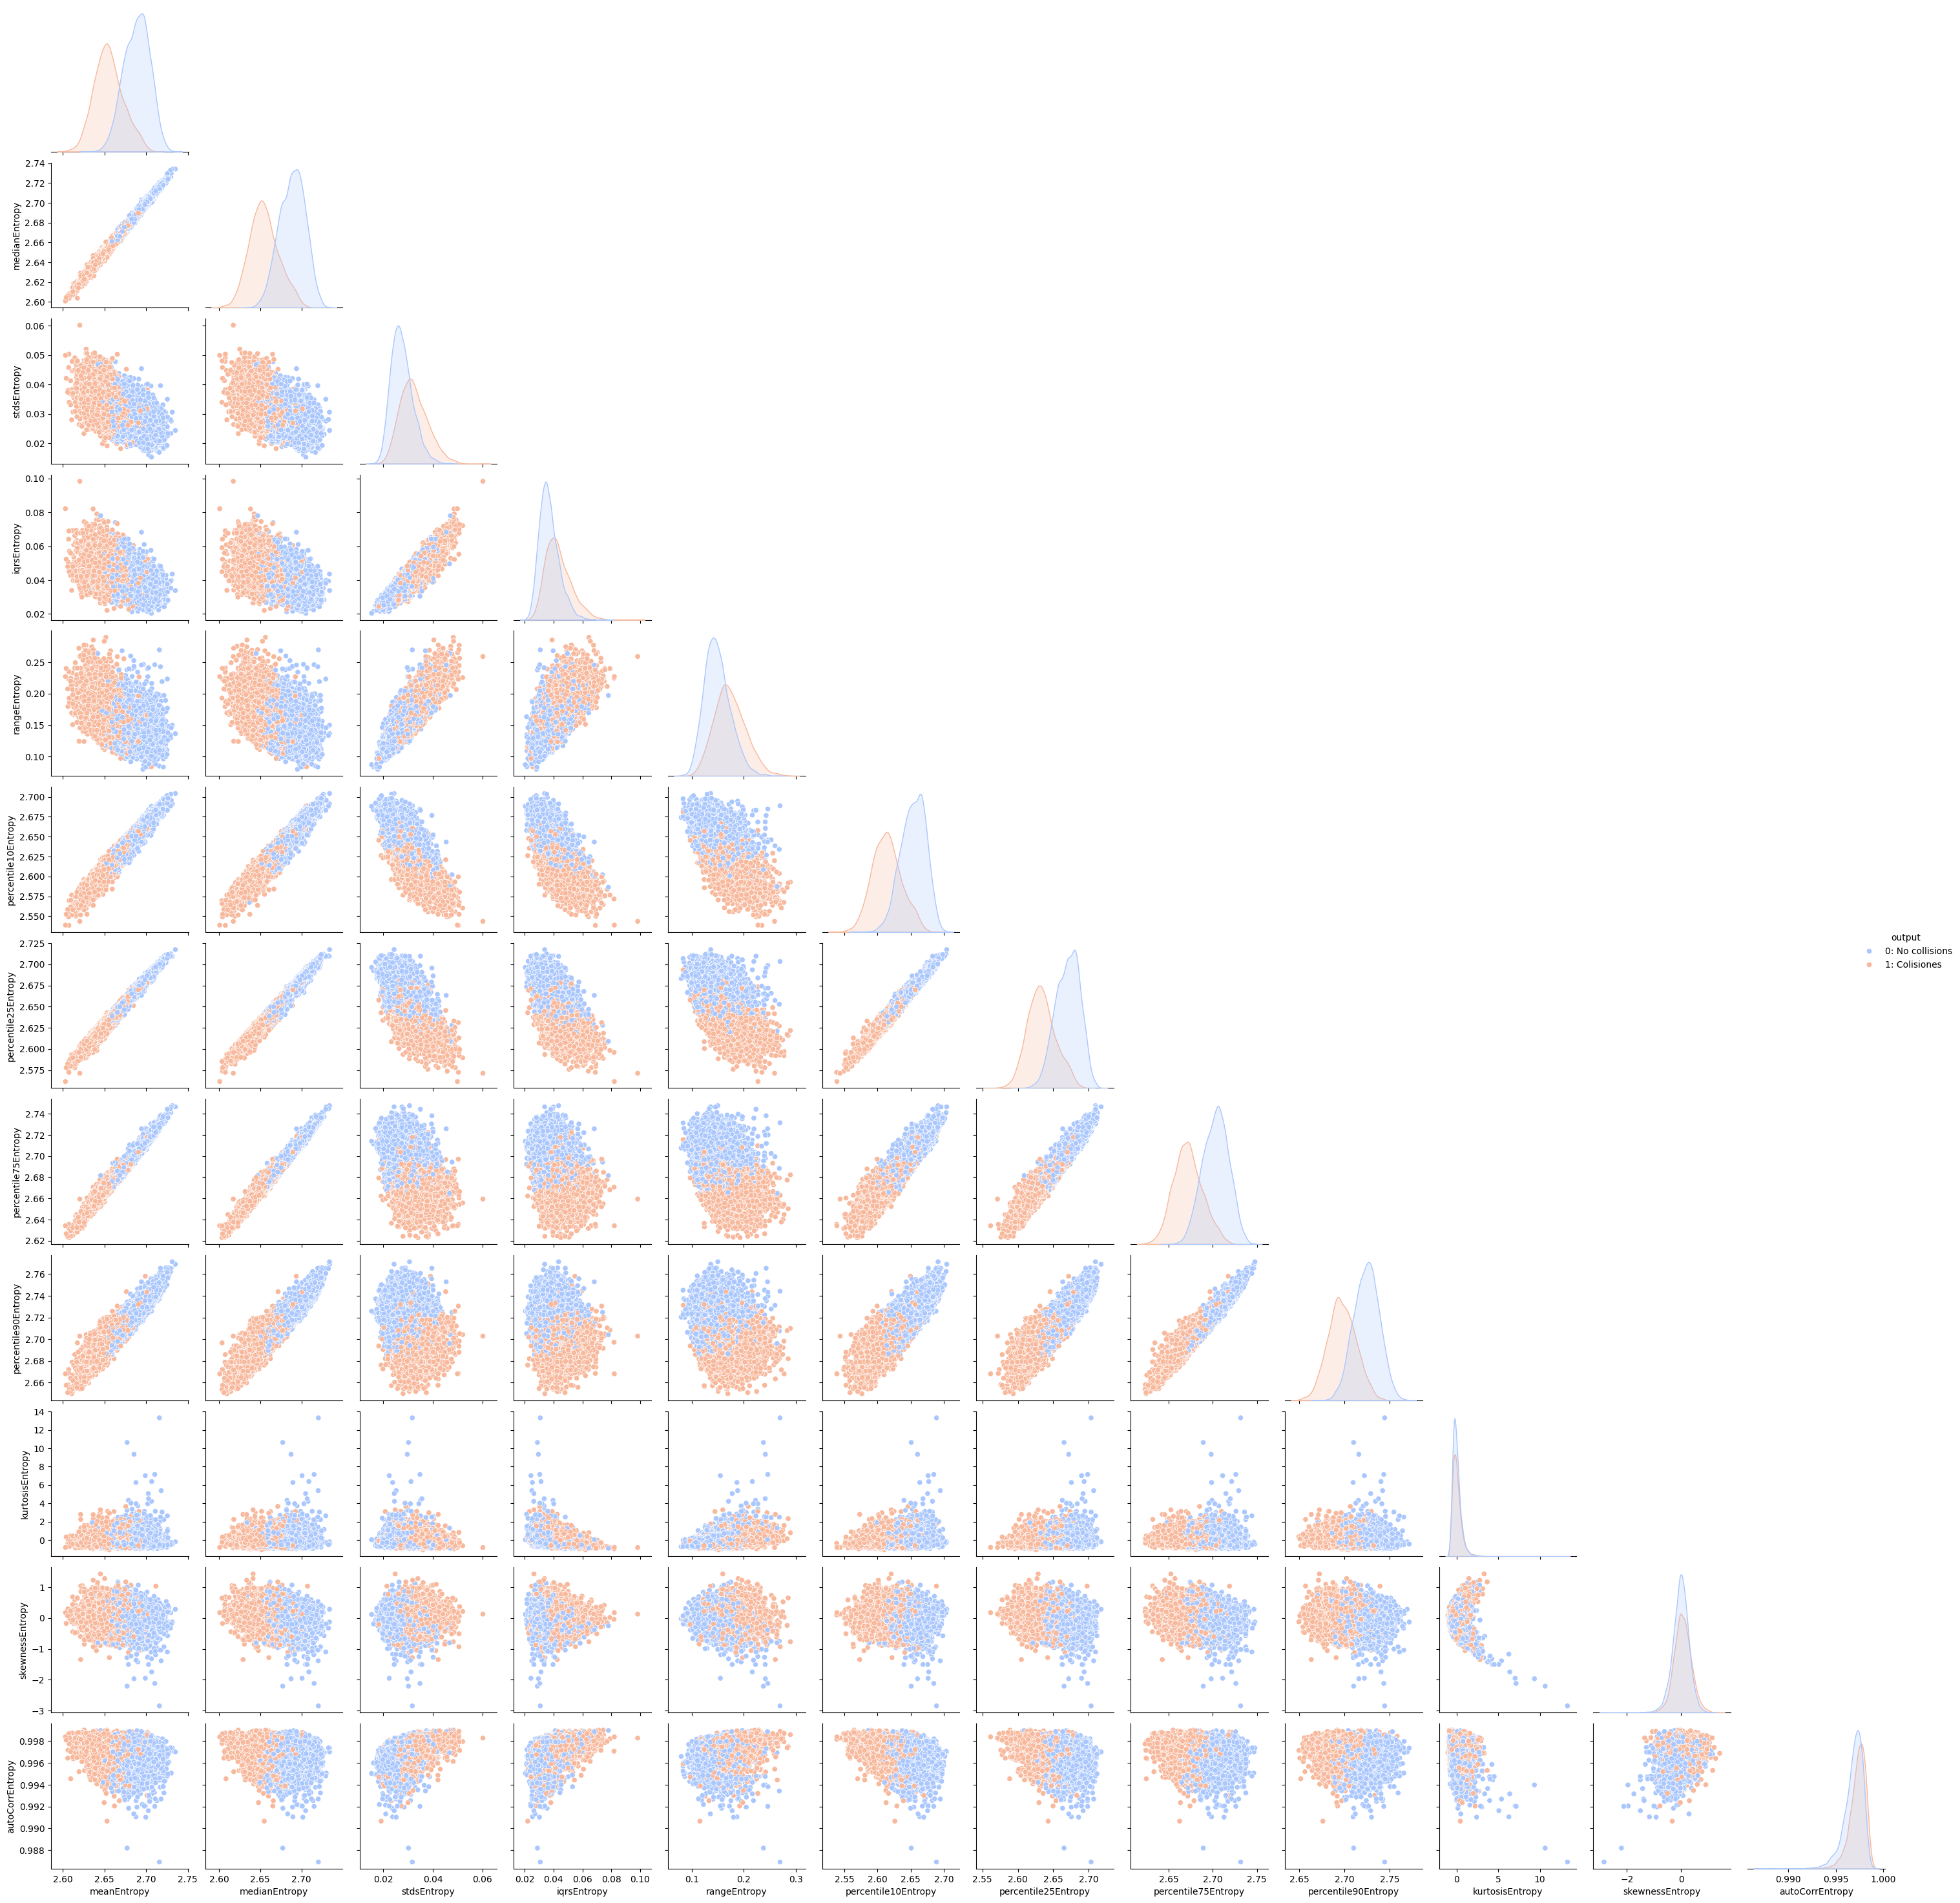

In [7]:
pairplot = sns.pairplot(data, vars=["meanEntropy","medianEntropy","stdsEntropy","iqrsEntropy","rangeEntropy","percentile10Entropy", "percentile25Entropy", "percentile75Entropy", "percentile90Entropy", "kurtosisEntropy", "skewnessEntropy", "autoCorrEntropy"], hue='output', palette='coolwarm',corner=True)
new_labels = ['0: No collisions', '1: Colisiones']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

## Boxplots

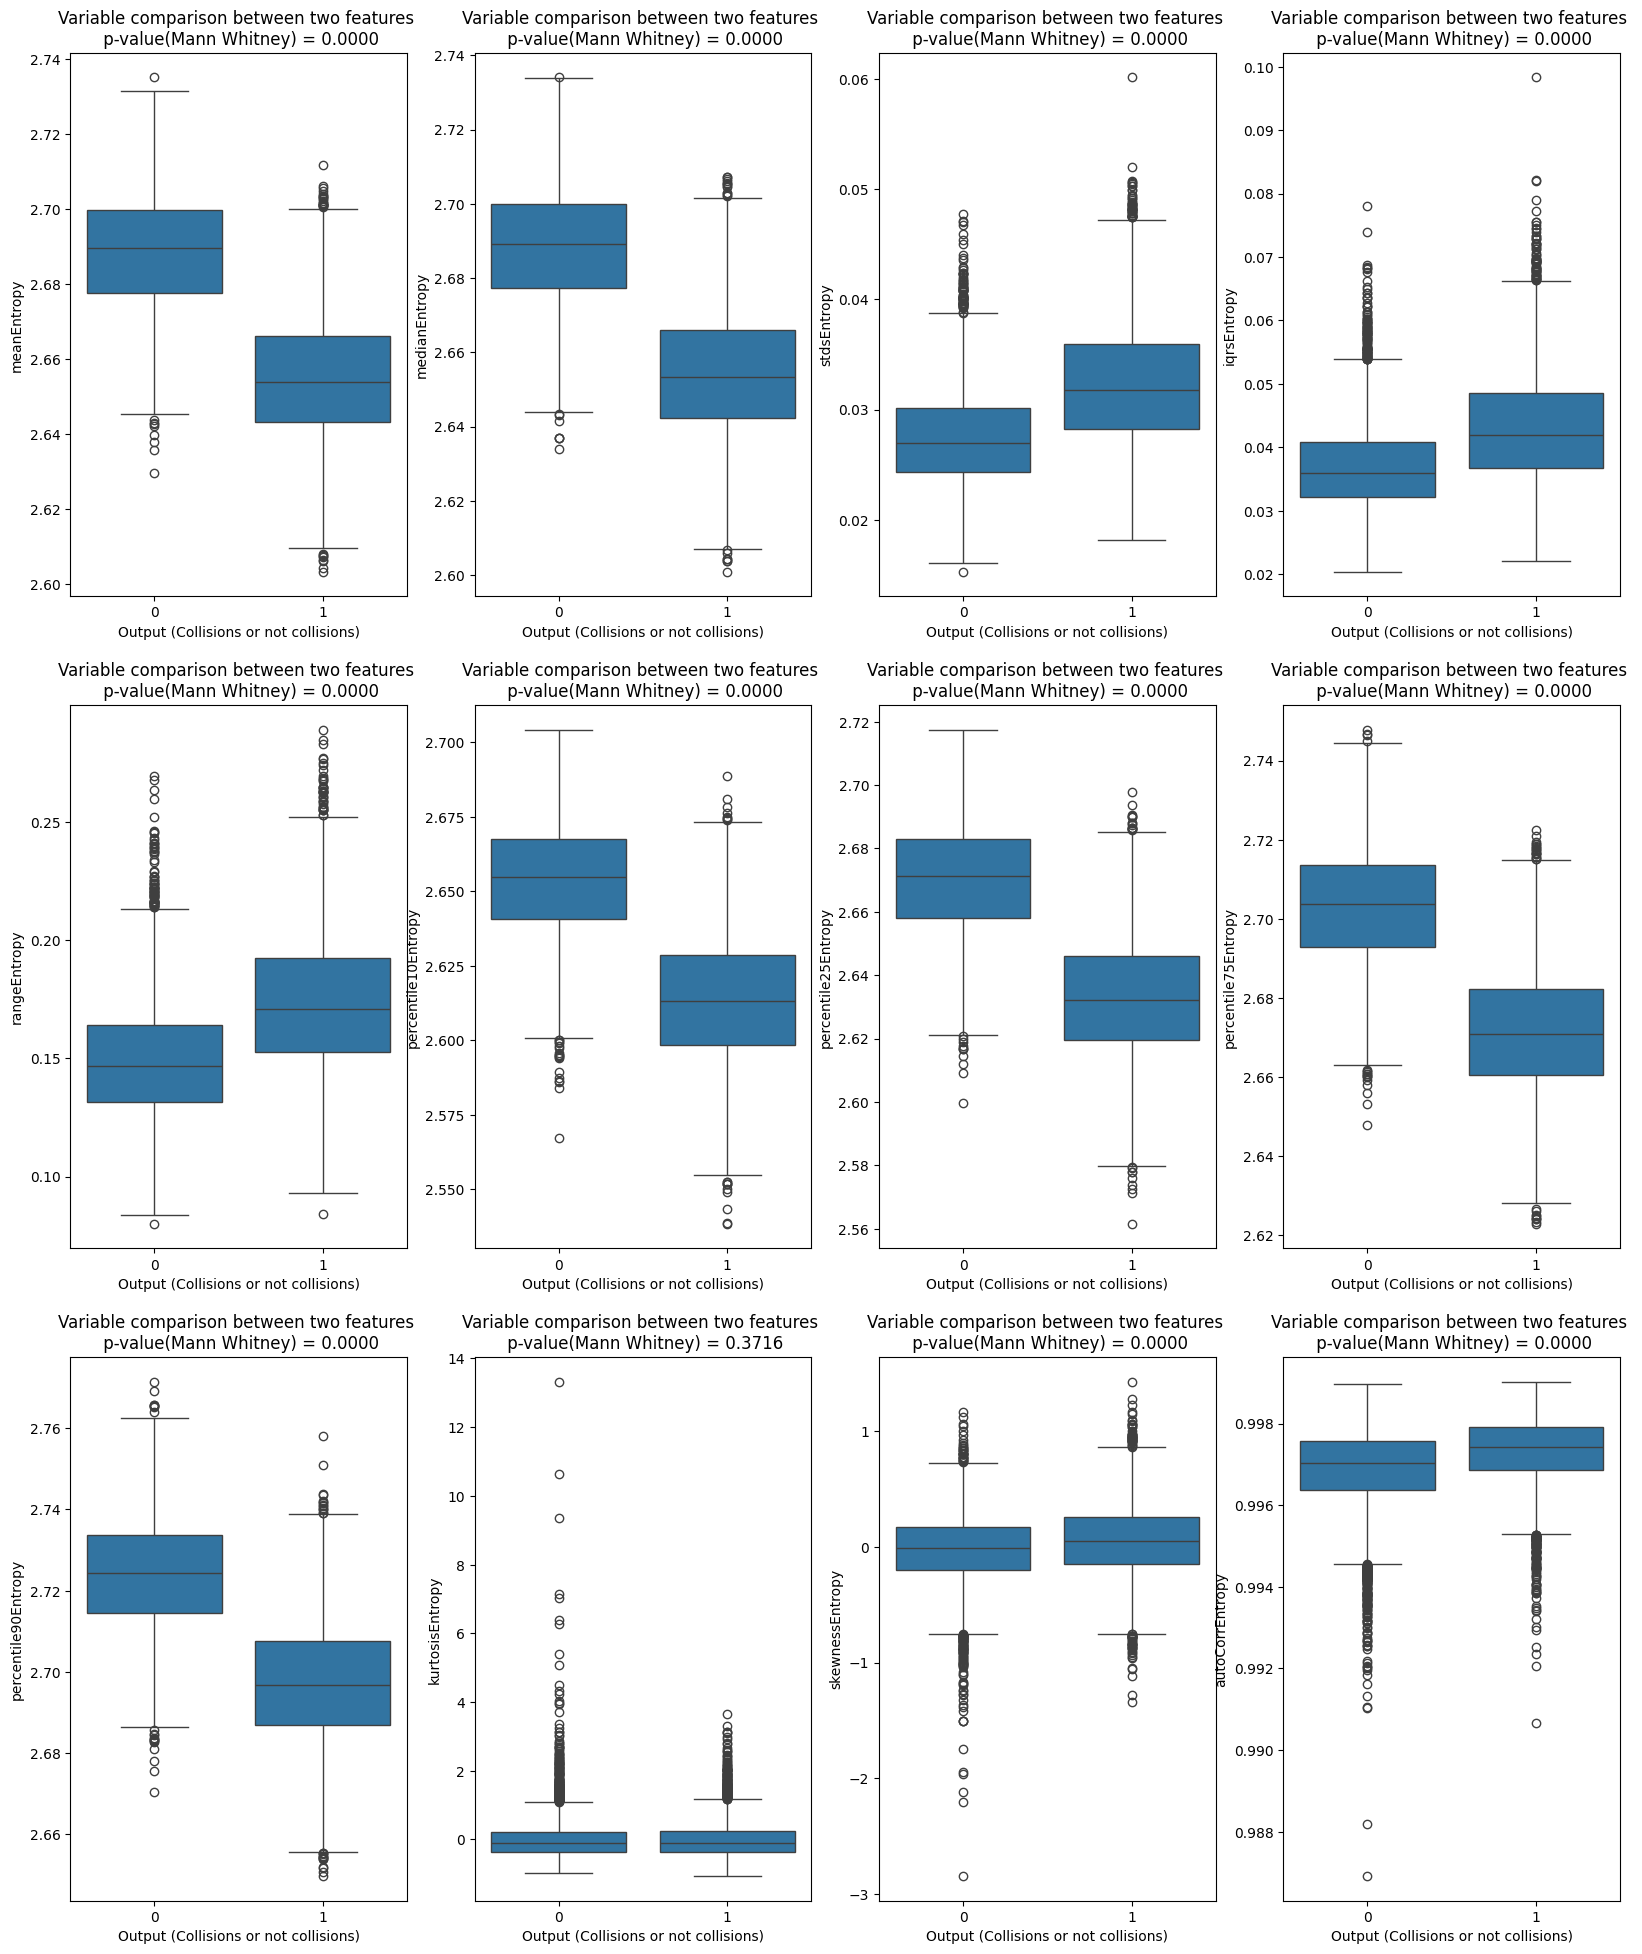

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 24))
axes = axes.flatten()
for num,i in enumerate(["meanEntropy","medianEntropy","stdsEntropy","iqrsEntropy","rangeEntropy","percentile10Entropy", "percentile25Entropy", "percentile75Entropy", "percentile90Entropy", "kurtosisEntropy", "skewnessEntropy", "autoCorrEntropy"]):
    Cvalues = data[data["output"] == 1][i].values
    NCvalues = data[data["output"] == 0][i].values
    u_stat, p_value = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='output', y=i, data=data)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value:.4f}')
    plt.xlabel("Output (Collisions or not collisions)")
    plt.ylabel(i)

plt.show()

# Skope Rules for output = 1 (collision class)

In [9]:
param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = True, rules_path = res_path+"skope_rules_collisions.csv", save_model = True, save_path = res_path+"skope_best_collisions.sav")


Time spent for Randomized Search:  169.8142054080963  s
0.7339263864811792 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.7927182530299922 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7723853784016852 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7523507788566383 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.7888631917175362 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.8156879146629177 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.803140304633204 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8149819388415714 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.81627908296244 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.81627908296244 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Randomized

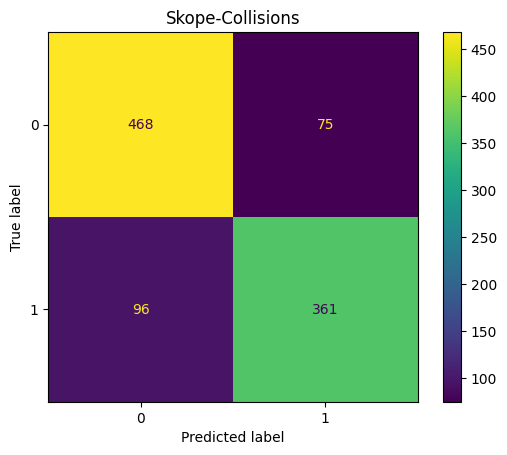

ACC = 0.829, F1 = 0.8085106382978723, PPV = 0.8279816513761468, NPV = 0.8297872340425532, TPR = 0.7899343544857768, TNR = 0.861878453038674

TP = 361, FP = 75, TN = 468, FN = 96


In [10]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-Collisions")


# Skope rules for output = 0 (non collision)

Swap labels to denote non collisions with 1


In [11]:
y_train = 1-y_train
y_test = 1-y_test
y_cal = 1- y_cal

In [12]:
# parameters optimization with RandomizedCV

param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = True, rules_path = res_path+"skope_rules_noncollisions.csv", save_model = True, save_path = res_path+"skope_best_noncollisions.sav")


Time spent for Randomized Search:  170.15078783035278  s
0.6036400582328024 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.8524605926011649 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.8068992528800261 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.6480036304580218 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8479211035785683 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.8666977221872145 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8648801170673319 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8674879330533866 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.8644884852395058 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8637448074183514 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Rand

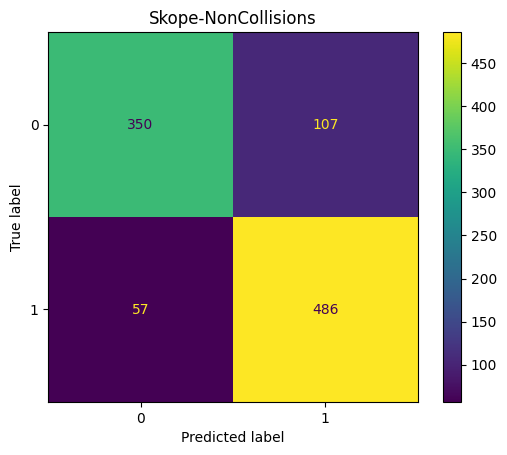

ACC = 0.836, F1 = 0.8556338028169014, PPV = 0.8195615514333895, NPV = 0.85995085995086, TPR = 0.8950276243093923, TNR = 0.7658643326039387

TP = 486, FP = 107, TN = 350, FN = 57


In [13]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-NonCollisions")